<a href="https://colab.research.google.com/github/CelikAbdullah/deep-learning-notebooks/blob/main/Deep%20Reinforcement%20Learning/Value%20Based/Dueling%20DDQN%20with%20PER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import gym
import time
from matplotlib import pyplot as plt
from itertools import count
import os
import imageio
from PIL import Image
import PIL.ImageDraw as ImageDraw

# Prioritized Replay Buffer (PER)

PER helps us to build a smarter way to replay experiences. It prioritize the replay of meaningful experiences.
In DQN, DDQN and Dueling DDQN we sampled experiences from the replay buffer uniformly at random. A better strategy would be to sample and learn from "surprising" experiences with an unexpected value.
Intuitively, we can think of them as follows: if a sample leads to a large difference between expectation and reality, then the agent should learn something from that.

The agent can obtain this measure of surprise by the absolute TD error. In PER, we will use TD errors to calculate priorities and from priorities we calculate probabilities. Using the probabilities, we can then sample from the replay buffer.

# Priotization

The are two ways to priotize samples:

## Rank-based prioritization

For rank-based prioritization, we calculate the priorities as the reciprocal of the rank of that sample:

$p_i = \dfrac{1} {rank(i)}$

Meaning of $rank(i)$: the position of sample $i$ when sorted in descending order by the absolute TD error. E.g. sample with highest absolute TD error gets rank 1.

## Proportional prioritization

In proportional prioritization, we can use the absolute TD error of sample $i$, denoted as $\delta_i$ and add a small constant, denoted as $\epsilon$, to make sure zero TD error samples still have a chance of being replayed:

$p_i = |\delta_i| + \epsilon$

## From scaled priorities to probabilities

The priority values $p_i$ are getting scaled by exponentiating it to $\alpha$ which is a hyperparameter in the range $[0,1].$ $\alpha$ allows us to interpolate between uniform and prioritized sampling. Further, it allows to perform stochastic prioritization.

If $\alpha$ is 0: all values become 1; an equal priority.

If $\alpha$ is 1: all values are the same as the absolute TD error; the priority is proportional to the absolute TD error

If $\alpha$ is between 0 and 1: we blend the two sampling strategies

To convert from scaled priorities to actual propbabilities only by dividing their values by the sum of the values:

$P(i) = \dfrac {p_{i}^\alpha} {\sum_{k} p_{k}^\alpha}$


These probabilities are then used later to draw samples from the replay buffer.

# Weighted importance-sampling weights

Another importance concept is to mitigate the pritization bias using weights. The sampling of experiences from the replay buffer in the implementations of DQN, DDQN and dueling DDQN was done uniformly at random. Since priotization means we are not doing that, then the probability distribution of samples we get is different from the uniform distribution.
Using a prioritized experience replay mechanism, we over-sample those experiences with high priority. Therefore, we have to use weights to down-weight the impact of the sampled term.

These weights are computed as follows:

$w_i = (\dfrac{1}{N} * \dfrac{1}{P(i)})^\beta$, whereas $N$ is the number of samples, $P(i)$ is the probability of sample $i$ and $\beta$ is a hyperparameter that allows us to tune the degree of the corrections. With $\beta = 0$ we have no correction of the bias and with $\beta=1$ we have full correction of the bias.

We also normalize the weights by their maximum. As a result, the max weight becomes 1 and all other weights scale down the TD errors:

$w_i = \dfrac{w_i}{max_j(w_j)}$

During training, we multiply the weight of sample $i$ ($w_i)$ together with the TD error $\delta_i$. So, instead of using the TD errors straight in the gradient updates, we multiply them by the importance sampling weights $w_i$ and scale all TD errors down to compensate for the mismatch in the distribution.

# Implementation of a Prioritized Replay Buffer

Putting all pieces together we obtain the following prioritized replay buffer:

In [ ]:
class PrioritizedReplayBuffer():
  def __init__(self,
               max_samples=10000,
               batch_size=64,
               rank_based=False,
               alpha=0.6,
               beta0=0.1,
               beta_rate=0.99992,
               eps = 1e-6):
    self.max_samples = max_samples
    self.memory = np.empty(shape=(self.max_samples, 2), dtype=np.ndarray)
    self.batch_size = batch_size
    self.n_entries = 0
    self.next_index = 0
    self.td_error_index = 0
    self.sample_index = 1
    self.rank_based = rank_based # if not rank_based, then proportional
    self.alpha = alpha # how much prioritization to use 0 is uniform (no priority), 1 is full priority
    self.beta = beta0 # bias correction 0 is no correction 1 is full correction
    self.beta0 = beta0 # beta0 is just beta's initial value
    self.beta_rate = beta_rate
    self.eps = eps

  def update(self, idxs, td_errors):
    self.memory[idxs, self.td_error_index] = np.abs(td_errors)
    if self.rank_based:
      sorted_arg = self.memory[:self.n_entries, self.td_error_index].argsort()[::-1]
      self.memory[:self.n_entries] = self.memory[sorted_arg]

  def store(self, sample):

    # initially, set the priority to the maximum
    priority = 1.0
    # during exploration, the priorities are not known for brand-new samples because
    # those have not been evaluated with the networks to get a TD error term.
    # To get around this, PER initializes the priority of a brand-new sample according
    # to the maximum priority of any priority thus far, thus favoring those terms during
    # sampling later
    if self.n_entries > 0:
      priority = self.memory[:self.n_entries, self.td_error_index].max()

    # insert priority & sample (experience) into the memory
    self.memory[self.next_index, self.td_error_index] = priority
    self.memory[self.next_index, self.sample_index] = np.array(sample)

    # increase the variable
    self.n_entries = min(self.n_entries + 1, self.max_samples)
    self.next_index += 1
    self.next_index = self.next_index % self.max_samples

  def _update_beta(self):
    # a hyperparameter that allows us to tune the degree of the corrections of the bias
    # training is highly unstable at the beginning and importance sampling corrections
    # matter more near the end of the training. Thus, beta starts small and anneals towards
    # one
    self.beta = min(1.0, self.beta * self.beta_rate**-1)
    return self.beta

  # idea of prioritized sampling:
  # weigh the samples so that "important" ones are drawn more frequently for training
  def sample(self, batch_size=None):

    #
    batch_size = self.batch_size if batch_size == None else batch_size
    self._update_beta()
    entries = self.memory[:self.n_entries]

    # rank-based priorization
    if self.rank_based:
      priorities = 1/(np.arange(self.n_entries) + 1)
    # proportional priorization
    else:
      priorities = entries[:, self.td_error_index] + self.eps

    # the priorities are getting scaled
    scaled_priorities = priorities**self.alpha
    # now, we can compute the probability distribution for sampling
    probs = np.array(scaled_priorities/np.sum(scaled_priorities), dtype=np.float64)

    # compute the importance sampling weights using the probabilities & normalize the weights
    weights = (self.n_entries * probs)**-self.beta
    normalized_weights = weights/weights.max()

    # sample indices of the samples in the replay buffer using the probabilities
    idxs = np.random.choice(self.n_entries, batch_size, replace=False, p=probs)

    # get the samples using the indices
    samples = np.array([entries[idx] for idx in idxs])

    # stack the samples by ids, weights and experience tuples and return them
    samples_stacks = [np.vstack(batch_type) for batch_type in np.vstack(samples[:, self.sample_index]).T]
    idxs_stack = np.vstack(idxs)
    weights_stack = np.vstack(normalized_weights[idxs])

    return idxs_stack, weights_stack, samples_stacks

  def __len__(self):
    return self.n_entries

  def __repr__(self):
    return str(self.memory[:self.n_entries])

  def __str__(self):
    return str(self.memory[:self.n_entries])

# Exploration Strategies

The GreedyStrategy will always select the maximum Q-value.

In [ ]:
# the strategy we will use in the evaluation phase
class GreedyStrategy():
  def __init__(self):
    self.exploratory_action_taken = False

  def select_action(self, model, state):
    with torch.no_grad():
      # get the q-value of each action given the state
      q_values = model(state).cpu().detach().data.numpy().squeeze()

      # return the index of the action with the highest estimate
      return np.argmax(q_values)

The exponential $\epsilon$-greedy strategy a decaying epsilon value so that the probability of exploration is higher at the beginning and the probability of exploitation is higher at the end of the training phase.

In [ ]:
# the strategy we will use in the training phase
class EGreedyExpStrategy():
  '''
  In the exponentially decaying strategy, the epsilon value is decaying in an exponential curve.
  '''

  def __init__(self, init_epsilon=1.0, min_epsilon=0.1, decay_steps=20000):
    self.epsilon = init_epsilon
    self.init_epsilon = init_epsilon
    self.decay_steps = decay_steps
    self.min_epsilon = min_epsilon
    self.epsilons = 0.01 / np.logspace(-2, 0, decay_steps, endpoint=False) - 0.01
    self.epsilons = self.epsilons * (init_epsilon - min_epsilon) + min_epsilon
    self.t = 0

  def _epsilon_update(self):
    self.epsilon = self.min_epsilon if self.t >= self.decay_steps else self.epsilons[self.t]
    self.t += 1

    return self.epsilon

  def select_action(self, model, state):
    with torch.no_grad():
      q_values = model(state).detach().cpu().data.numpy().squeeze()

    # we draw the random number from a uniform distribution and compare it to epsilon
    # if it is higher, we use the argmax of the q-values
    # otherwise, we use a random action
    if np.random.rand() > self.epsilon:
      action = np.argmax(q_values)
    else:
      action = np.random.randint(len(q_values))

    # adjust the epsilon value
    self._epsilon_update()

    return action

# Dueling Q Network

In [ ]:
class DuelingQNetwork(nn.Module):
  def __init__(self,
               input_dim,
               output_dim,
               hidden_dims=(32,32),
               activation_fc=F.relu):
    super(DuelingQNetwork, self).__init__()
    self.activation_fc = activation_fc
    self.input_layer = nn.Linear(input_dim, hidden_dims[0])
    self.hidden_layers = nn.ModuleList()
    for i in range(len(hidden_dims)-1):
      hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i+1])
      self.hidden_layers.append(hidden_layer)

    self.value_output = nn.Linear(hidden_dims[-1], 1)
    self.advantage_output = nn.Linear(hidden_dims[-1], output_dim)

    device = "cpu"
    if torch.cuda.is_available():
      device = "cuda:0"

    self.device = torch.device(device)
    self.to(self.device)

  def _format(self, state):
    x = state
    if not isinstance(x, torch.Tensor):
      x = torch.tensor(x, device=self.device, dtype=torch.float32)
      x = x.unsqueeze(0)
    return x

  def forward(self, state):
    x = self._format(state)
    x = self.activation_fc(self.input_layer(x))
    for hidden_layer in self.hidden_layers:
      x = self.activation_fc(hidden_layer(x))

    # approximate the action-advantage function
    a = self.advantage_output(x)
    # approximate the state-value function
    v = self.value_output(x)

    # expand v since it's a single value that will be added to 'a'
    v = v.expand_as(a)

    # put approximated action-advantage & state-value functions together
    # to estimate the Q values
    q = v + a - a.mean(1, keepdim=True).expand_as(a)

    return q

  def numpy_float_to_device(self, variable):
    variable = torch.from_numpy(variable).float().to(self.device)
    return variable

  def load(self, experiences):
    states, actions, new_states, rewards, is_terminals = experiences
    states = torch.from_numpy(states).float().to(self.device)
    actions = torch.from_numpy(actions).long().to(self.device)
    new_states = torch.from_numpy(new_states).float().to(self.device)
    rewards = torch.from_numpy(rewards).float().to(self.device)
    is_terminals = torch.from_numpy(is_terminals).float().to(self.device)
    return states, actions, new_states, rewards, is_terminals

# Dueling DDQN agent

In [ ]:
class DuelingDDQN():
  def __init__(self,
               env,
               replay_buffer,
               online_model,
               target_model,
               optimizer,
               training_strategy,
               evaluation_strategy,
               episodes,
               max_gradient_norm,
               tau,
               gamma = 1.0,
               update_steps = 1,
               max_minutes = 30,
               max_episodes = 10000,
               goal_mean_100_reward = 475,
               warmup_batches = 5):

    self.env = env
    self.replay_buffer = replay_buffer
    self.online_model = online_model
    self.target_model = target_model
    self.optimizer = optimizer
    self.training_strategy = training_strategy
    self.evaluation_strategy = evaluation_strategy
    self.episodes = episodes
    self.max_gradient_norm = max_gradient_norm
    self.gamma = gamma
    self.update_steps = update_steps
    self.max_minutes = max_minutes
    self.max_episodes = max_episodes
    self.goal_mean_100_reward = goal_mean_100_reward
    self.warmup_batches = warmup_batches
    self.evaluation_scores = []
    self.episode_timestep = []
    self.tau = tau



  def interaction_step(self, state):
    ''' Interact with the environment and create the experience. '''

    # select an action
    action = self.training_strategy.select_action(online_model, state)

    # take the selected action
    new_state, reward, is_terminal, info = self.env.step(action)

    # check TimeLimit of the CartPole environment
    is_truncated = 'TimeLimit.truncated' in info and info['TimeLimit.truncated']
    is_failure = is_terminal and not is_truncated

    # create the experience as tuple
    experience = (state, action, reward, new_state, float(is_failure))

    # store the experience into the replay buffer
    self.replay_buffer.store(experience)

    # keep track of the timestep so that we know when to update the target network's weights
    self.episode_timestep[-1] += 1

    # return new state & the is_terminal flag to caller
    return new_state, is_terminal



  def update_network(self, tau=None):
    '''
    Apply Polyak Averaging to update the weights of the target network
    '''

    # determine the ratio of the online network that will be mixed
    # into the target network
    tau = self.tau if tau is None else tau

    # iterate throgh the weights
    for target, online in zip(self.target_model.parameters(),
                              self.online_model.parameters()):

      # determine the ratio we are taken from the target network
      target_ratio = (1.0 - tau) * target.data
      # detetermine the ration we are taken from online network
      online_ratio = tau * online.data

      # mix the weights of the online and target network
      mixed_weights = target_ratio + online_ratio

      # copy the mixed weights into the target network
      target.data.copy_(mixed_weights)


  def optimize_model(self, experiences):
    # extract the indices of the samples, their importance sampling weights, and the samples
    idxs, weights, (states, actions, rewards, next_states, is_terminals) = experiences

    # bring the importance sampling weights into the correct format
    weights = self.online_model.numpy_float_to_device(weights)
    batch_size = len(is_terminals)

    # query the online network to get the index of the highest-valued
    # action of the next state
    index_of_highest_valued_q_values = self.online_model(next_states).max(1)[1]

    # query the q values of the next state according to target network
    q_values_of_target_network = self.target_model(next_states).detach()

    # index the Q values given by the target network
    # with the action indices given be the online network
    highest_valued_q_values = q_values_of_target_network[np.arange(batch_size), index_of_highest_valued_q_values].unsqueeze(1)

    # create the target values
    target_q_values = rewards + (self.gamma * highest_valued_q_values * (1 - is_terminals))

    # get the current estimates
    predicted_q_values = self.online_model(states).gather(1, actions)

    # determine the loss; recall that we have to use the importance sampling weights
    td_error = predicted_q_values - target_q_values
    loss = (weights * td_error).pow(2).mul(0.5).mean()

    # zero out the gradients
    self.optimizer.zero_grad()

    # compute the gradients
    loss.backward()

    # to implement the Huber loss, we compute the MSE loss (as above) and
    # now we set the all gradients larger than a threshold to a fixed magnitude
    # value; so we clip the magnitude of the gradients
    torch.nn.utils.clip_grad_norm_(self.online_model.parameters(), self.max_gradient_norm)

    # update the weights
    self.optimizer.step()

    # compute the priorities
    priorities = np.abs(td_error.detach().cpu().numpy())
    # update the samples in the replay buffer
    self.replay_buffer.update(idxs, priorities)

  def train(self):
    '''Train the DQN agent. '''

    # get the starting time of the training phase
    training_start = time.time()

    # before we start, make sure that the online and target network has the same weights
    self.update_network(tau=1.0)

    # for each episode, do the following
    for episode in range(self.episodes):
      state = self.env.reset()
      is_terminal = False

      self.episode_timestep.append(0.0)

      for timestep in count():
        # interact with the environment & store the experience
        state, is_terminal = self.interaction_step(state)

        # check if we have enough experiences in the replay buffer
        if(len(self.replay_buffer) > self.replay_buffer.batch_size * self.warmup_batches):
          experiences = self.replay_buffer.sample()
          idxs, weights, samples = experiences
          experiences = self.online_model.load(samples)
          experiences = (idxs, weights) + (experiences,)
          self.optimize_model(experiences)


        # update the weights of the target network periodically
        if np.sum(self.episode_timestep) % self.update_steps == 0:
          # update the weights of the target network
          self.update_network()

        # break if current state was a terminal state
        if is_terminal:
          break

      # compute the evaluation score
      evaluation_score = self.evaluate()
      # store the evaluation score
      self.evaluation_scores.append(evaluation_score)


      mean_100_eval_score = np.mean(self.evaluation_scores[-100:])

      wallclock_elapsed = time.time() - training_start
      reached_max_minutes = wallclock_elapsed >= self.max_minutes * 60
      reached_max_episodes = episode >= self.max_episodes
      reached_goal_mean_reward = mean_100_eval_score >= goal_mean_100_reward

      training_is_over = reached_max_minutes or reached_max_episodes or reached_goal_mean_reward

      if training_is_over:
        if reached_max_minutes: print('Max minutes are reached')
        if reached_max_episodes: print('Max episodes are reached')
        if reached_goal_mean_reward: print('Goal mean reward is reached')
        break


    final_evaluation_score = self.evaluate(episodes=100)
    print(f"Final_evaluation score: {final_evaluation_score}")

    self.env.close()
    del self.env

    return final_evaluation_score

  def evaluate(self, episodes=1):
    ''' Evaluate the model. '''

    # keep track of the rewards
    rewards = []

    # for each episode (default: 1) do the following
    for _ in range(episodes):
      # get the initial state
      state = self.env.reset()
      # set is_terminal flag to False
      is_terminal = False

      # append a 0 to rewards list
      rewards.append(0)

      # for each timestep of the current episode, do the following
      for _ in count():
        # select an action using the evaluation strategy
        action = self.evaluation_strategy.select_action(self.online_model, state)
        # take the action in the environment
        state, reward, is_terminal, _ = self.env.step(action)
        # store the reward
        rewards[-1] += reward
        # if we land at a terminal state, finish the current episode
        if is_terminal: break

    # return the mean of the rewards to the caller
    return np.mean(rewards)

Let's train our Dueling DDQN agent with a prioritized experience replay:

In [ ]:
dqn_results = []
best_agent, best_eval_score = None, float('-inf')
SEEDS = (12, 34, 56, 78, 90)

# we let five DQN agents train, the one with the best evaluation score will be selected as the best one
# in each iteration, a different seed is used for creating the environment
for seed in SEEDS:
  # create an instance of the environment
  env = gym.make("CartPole-v1")
  env.seed(seed)



  # create an instance of the replay buffer
  replay_buffer = PrioritizedReplayBuffer(max_samples=20000,
                                          batch_size=64,
                                          rank_based=False, # let's use proportional prioritization
                                          alpha = 0.6,
                                          beta0 = 0.1,
                                          beta_rate=0.99995,
                                          eps = 1e-6

  )

  # define our action-selection policy for the training phase
  training_strategy = EGreedyExpStrategy(init_epsilon=1.0,
                                         min_epsilon=0.3,
                                         decay_steps=20000)

  # define our action-selection policy for the evaluation phase
  evaluation_strategy = GreedyStrategy()

  # obtain the number of variables used in each state and the number of actions
  nS, nA = env.observation_space.shape[0], env.action_space.n

  # build the online network
  online_model = DuelingQNetwork(nS, nA, hidden_dims=(512,128))

  # build the target network
  target_model = DuelingQNetwork(nS, nA, hidden_dims=(512,128))

  # define the number of episodes
  episodes = 10000

  # create an instance of the RMSprop optimizer
  lr = 0.0005
  optimizer = optim.RMSprop(online_model.parameters(), lr=lr)

  # define the our discount factor
  gamma = 1.0

  # number of steps when to update the target network
  update_steps = 1

  # define max minutes
  max_minutes = 20

  # define nr. of max episodes
  max_episodes = 10000

  # define mean reward value
  goal_mean_100_reward = 475

  # warmup batches
  warmup_batches = 5

  # define the max gradient norm
  max_gradient_norm = float('inf')

  # define tau for the update step
  tau = 0.1

  # create the DQN agent
  agent = DuelingDDQN(env,
                      replay_buffer,
                      online_model,
                      target_model,
                      optimizer,
                      training_strategy,
                      evaluation_strategy,
                      episodes,
                      max_gradient_norm,
                      tau,
                      gamma,
                      update_steps,
                      max_minutes,
                      max_episodes,
                      goal_mean_100_reward,
                      warmup_batches
                      )

  # let the DQN agent train
  final_evaluation_score = agent.train()

  if final_evaluation_score > best_eval_score:
    best_eval_score = final_evaluation_score
    best_agent = agent

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
<ipython-input-2-773de6264e08>:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with

Goal mean reward is reached
Final_evaluation score: 500.0
Goal mean reward is reached
Final_evaluation score: 500.0
Max minutes are reached
Final_evaluation score: 140.02
Max minutes are reached
Final_evaluation score: 500.0
Goal mean reward is reached
Final_evaluation score: 427.81


# Save model

In [ ]:
torch.save(best_agent.online_model.state_dict(), "/content/drive/MyDrive/Dueling DDQN with PER/DuelingDDQNWithPER_agent_final.pt")

# Visualization

In [ ]:
import os
import imageio
from PIL import Image as Im
import PIL.ImageDraw as ImageDraw
from IPython import display

In [ ]:
env = gym.make("CartPole-v1")
model = DuelingQNetwork(env.observation_space.shape[0], env.action_space.n, hidden_dims=(512,128))
model.load_state_dict(torch.load("/content/drive/MyDrive/Dueling DDQN with PER/DuelingDDQNWithPER_agent_final.pt"))
model.eval()

DuelingQNetwork(
  (input_layer): Linear(in_features=4, out_features=512, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=512, out_features=128, bias=True)
  )
  (value_output): Linear(in_features=128, out_features=1, bias=True)
  (advantage_output): Linear(in_features=128, out_features=2, bias=True)
)

In [ ]:
def create_gif(env, episodes):
  # list to keep track of frames
  frames = []

  for episode in range(1, episodes + 1):
    # get the initial state
    state = env.reset()

    # for each timestep, do the following
    for t in range(500):
      # get the Q-value estimates
      q_values = model(state)
      # select the action (greedily)
      action = np.argmax(q_values.data.numpy())

      # get the frame & store it
      frame = env.render(mode='rgb_array')

      # prepare the frame
      im = Im.fromarray(frame)
      drawer = ImageDraw.Draw(im)
      if np.mean(im) < 128:
        text_color = (255,255,255)
      else:
        text_color = (0,0,0)
        drawer.text((im.size[0]/20,im.size[1]/18), f'Episode: {episode+1}', fill=text_color)
        drawer.text((im.size[0]/20,im.size[1]/8), f'Timestep: {t+1}', fill=text_color)

      # store the frame
      frames.append(im)

      # take the action in the environment
      state, _, is_terminal, _ = env.step(action)

      # if we land at a terminal state, break
      if is_terminal:
        break

    # close the environment
    env.close()

    # create the gif
    imageio.mimwrite(os.path.join('/content/drive/MyDrive/Gif/', 'DuelingDDQNWithPER_agent.gif'), frames, fps=60)

In [ ]:
episodes = 5
env = gym.make('CartPole-v1')
create_gif(env, episodes)

/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


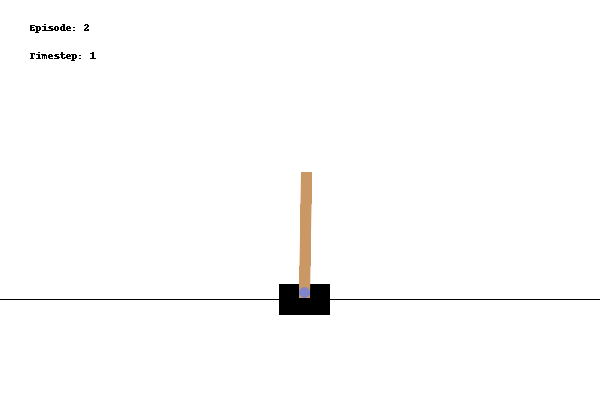

In [ ]:
from IPython import display
display.Image(open('/content/drive/MyDrive/Gif/DuelingDDQNWithPER_agent.gif','rb').read())